In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 15 18:12:38 2017

@author: VANLOI
"""
from __future__ import print_function, division

#import sys
import numpy
import numpy as np
import downhill
import theano
import theano.tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import pandas as pd
from hiddenLayer import HiddenLayer
from hiddenLayer import dA

from ProcessingData import load_data, normalize_data
from Methods import auc_density, auc_AEbased
from Plot_Curves import Plotting_End2End_RE, Plotting_Pre_RE, Plotting_AUC_RE, Plotting_Pre_RE1
from Plot_Curves import Plotting_AUC_Batch_Size, Plotting_Monitor, plot_auc_size_input, visualize_hidden1
from Plot_Curves import Plotting_Loss_Component, plot_auc_size_1, plot_auc_size_2
from nnet_architecture import hyper_parameters
from stopping_para import stopping_para_shrink
#import timeit as tm

path = "./Results/Exp_Hidden/"

def check_weight_update(sda):
    np.set_printoptions(precision=4, suppress=True)
    "Check whether weights matrix is updated or not"
    for i in range(sda.n_layers):
        print("\n %d" %i)
        print (sda.Autoencoder_layers[i].W.get_value(borrow=True))

    for j in range(sda.n_layers, 2*sda.n_layers):
        print("\n %d" % j)
        print (sda.Autoencoder_layers[j].W.eval())



class SdA(object):
    def __init__(self, numpy_rng, theano_rng=None, n_ins=100,
                 hidden_layers_sizes=[50, 30], corruption_levels=[0.1, 0.1]):

        self.encoder = []
        self.dA_layers = []
        self.params = []
        self.n_layers = len(hidden_layers_sizes)
        self.decoder = []

        assert self.n_layers > 0
        if not theano_rng:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 30))

        self.x = T.matrix('x') 

        "*************** Encoder **************************"
        for i in range(self.n_layers):

            if i == 0:
                input_size = n_ins
                layer_input = self.x
            else:
                input_size = hidden_layers_sizes[i - 1]
                layer_input = self.encoder[-1].output
            act_function = T.tanh

            encoder_layer = HiddenLayer(rng=numpy_rng,
                                    input       = layer_input,
                                    n_in        = input_size,
                                    n_out       = hidden_layers_sizes[i],
                                    activation  = act_function)
            self.encoder.append(encoder_layer)
            self.params.extend(encoder_layer.params)

            "**************************************************"
            """Construct a dAE that shared weights with this layer"""
            dA_layer = dA(numpy_rng = numpy_rng,
                          theano_rng = theano_rng,
                          #input = layer_input,               
                          n_visible = input_size,
                          n_hidden  = hidden_layers_sizes[i],
                          W         = encoder_layer.W,
                          bhid      = encoder_layer.b)             

            self.dA_layers.append(dA_layer)

        "*************** Decoder *****************************"
        i = self.n_layers-1
        while (i >=0):
            input_size = hidden_layers_sizes[i]
            if ( i > 0):
                output_size = hidden_layers_sizes[i-1]
            else:
                output_size =  n_ins

            if (i==self.n_layers-1):
                layer_input = self.encoder[-1].output
            else:
                layer_input = self.decoder[-1].output

            decoder_layer = HiddenLayer(rng     = numpy_rng,
                                        input   = layer_input,
                                        n_in    = input_size,
                                        n_out   = output_size,
                                        activation = T.tanh,
                                        W = self.encoder[i].W.T,
                                        b = self.dA_layers[i].b_prime)    #this is bvis of dA
            self.decoder.append(decoder_layer)
            self.params.append(decoder_layer.b)
            i = i - 1

        "******************* End To End Cost function ************************"
        y = self.decoder[-1].output
        self.recon = (((self.x - y)**2).mean(1)).mean()
        self.end2end_cost = self.recon


    "****** Error on train_x and valid_x before optimization process **********"
    def Loss_train_valid(self, train_x, valid_x):
        index = T.lscalar('index')

        train_size = train_x.get_value().shape[0]
        tm = theano.function([index],
                             outputs = self.end2end_cost,
                             givens={self.x: train_x[index : train_size]})

        valid_size = valid_x.get_value().shape[0]
        vm = theano.function([index],
                             outputs = self.end2end_cost,
                             givens={self.x: valid_x[index : valid_size]})

        return tm(0), vm(0)



    "Get data from the middle hidden layer Deep Autoencoder"
    def get_hidden_data(self,data_set):

        data_size = data_set.get_value().shape[0]
        index = T.lscalar('index')
        hidden_data = theano.function([index],
                                      outputs = self.encoder[-1].output,
                                      givens={self.x: data_set[index : data_size]})
        return hidden_data(0)

    "Get hidden data from hidden layer i-th for pre-training"
    def get_hidden_i(self,data_set, i):

        data_size = data_set.get_value().shape[0]
        index = T.lscalar('index')
        hidden_data = theano.function([index],
                                      outputs = self.encoder[i].output,
                                      givens={self.x: data_set[index : data_size]})
        return hidden_data(0)

    "Get data from the output of Autoencoder"
    def get_output_data(self,data_set):

        data_size = data_set.get_value().shape[0]
        index = T.lscalar('index')
        output_data = theano.function([index],
                                      outputs = self.decoder[-1].output,
                                      givens={self.x: data_set[index : data_size]})
        return output_data(0)


#************* Pre-traing for 200 epoches, no early-stopping *************"
    def pretrain_Early_stopping(self, numpy_rng, train_set, n_validate, data_name,
                                batch_size, pre_lr, corruptions):

        RE = np.empty([10000, self.n_layers])
        stop_epoch = np.empty([self.n_layers])

        for i in range(self.n_layers):
            cost, updates = self.dA_layers[i].get_cost_updates(corruptions[i], pre_lr)
            if (i == 0):
                train_x1 = train_set.get_value()
            else:
                train_x1 = self.get_hidden_i(train_set, i-1)

            valid_x = train_x1[:n_validate]
            train_x = train_x1[n_validate:]
            # adadelta, 'adagrad (default 0.01)' 'adam''esgd' 'nag''rmsprop' 'rprop' 'sgd'
            opt = downhill.build(algo = 'sgd', params= self.dA_layers[i].params, loss = cost)
            train = downhill.Dataset(train_x, batch_size = batch_size, rng = numpy_rng)
            valid = downhill.Dataset(valid_x, batch_size = len(valid_x), rng = numpy_rng)

            epoch = 0
            re = np.empty([10000])
            for tm1, vm1 in opt.iterate(train,
                                      valid,
                                      patience = 100,            #100
                                      validate_every= 5,         #5
                                      min_improvement = 1e-3,    #4
                                      learning_rate = pre_lr,    #1e-2
                                      momentum = 0.0,
                                      nesterov = False):
                re[epoch] = tm1['loss']
                epoch = epoch +1
                if (epoch == 200):
                    break

            RE[:,i] = re
            stop_epoch[i] = epoch

        print (' + Stopping epoch:', stop_epoch)
        Plotting_Pre_RE1(RE, stop_epoch, self.n_layers, 0.0, 0.1, batch_size, data_name, path)


    "Compute AUC for OCCs on latent data"
    def Compute_AUC_Hidden(self, train_set, test_set, actual, norm, data_name):

        output_test  = self.get_output_data(test_set)       
        train_hidden = self.get_hidden_data(train_set)     
        test_hidden  = self.get_hidden_data(test_set)      

        "Compute performance of classifiers on latent data"
        lof, cen, dis, kde, svm05, svm01 = auc_density(train_hidden, test_hidden, actual, norm)
        ae                               = auc_AEbased(test_set.get_value(), output_test, actual)
        return lof, cen, dis, kde, svm05, svm01, ae

    "**************************************************************************"
    def Save_Hidden_Data(self, train_set, test_set, data_name, path):

        train_hidden = self.get_hidden_data(train_set)      
        test_hidden  = self.get_hidden_data(test_set)      
        np.savetxt(path + data_name + "_train_z.csv", train_hidden, delimiter=",", fmt='%f' )
        np.savetxt(path + data_name + "_test_z.csv", test_hidden, delimiter=",", fmt='%f' )


    "******** Training End-to-End Early-stopping by Downhill Package *********"
    def End2end_Early_stopping(self, numpy_rng, dataset, n_validate, data_name,
                               batch_size, end2end_lr, algo, norm, patience, validation):

        train_X, test_X, actual = dataset
        valid_x = train_X.get_value()[:n_validate]
        train_x = train_X.get_value()[n_validate:]
        #train_x = train_x[:100]

        "for compute tm and vm before optimization process"
        t = theano.shared(numpy.asarray(train_x, dtype=theano.config.floatX), borrow=True)
        v = theano.shared(numpy.asarray(valid_x, dtype=theano.config.floatX), borrow=True)

        "Use downhill for training network"

        opt = downhill.build(algo = algo, params= self.params,
                             loss = self.end2end_cost, inputs = [self.x])

        train = downhill.Dataset(train_x, batch_size = batch_size, rng = numpy_rng)
        valid = downhill.Dataset(valid_x, batch_size = len(valid_x), rng = numpy_rng)

        "for monitoring before optimization process"
        stop_ep = 0


        for tm1, vm1 in opt.iterate(train,                        
                                  valid,
                                  patience = patience,                
                                  validate_every= validation,           
                                  min_improvement = 1e-3,       
                                  #learning_rate =  end2end_lr,
                                  momentum = 0.0,
                                  nesterov = False):


            stop_ep = stop_ep + 1
#
##            "******* Classification Results after End to End training ******"
#            if ((stop_ep%1 == 0) and (stop_ep > 0)):
#                lof,cen,dis,kde,svm05,svm01,ae = self.Compute_AUC_Hidden(train_X, test_X, actual, norm, data_name)
#                a = [stop_ep, lof, cen, dis, kde, svm05, svm01, ae]
#            monitor = np.append(monitor, a)

            if (stop_ep >= 1000):
                break

        #Plotting AUC and save to csv file
#        monitor = np.reshape(monitor, (-1,8))
#        Plotting_Monitor(monitor, 0.4, 1.0, data_name, path)
#        np.savetxt(path + data_name + "_monitor_auc.csv", monitor, delimiter=",", fmt='%f' )

        return  [stop_ep, vm1['loss'], tm1['loss']]



def train_SdAE(pre_lr=0.01, end2end_lr=1e-4, algo = 'sgd',
             dataset=[], data_name = "WBC", n_validate = 0, norm = "maxabs",
             batch_size=10, hidden_sizes = [1,1,1], corruptions = [0.0, 0.0, 0.0],
             patience = 1, validation = 1):

    numpy_rng = numpy.random.RandomState(89677)   
    train_X, test_X, actual = dataset             

    input_size = train_X.get_value().shape[1]     
    train_x    = train_X.get_value()[n_validate:]   
    n_train_batches   = train_x.shape[0]
    n_train_batches //= batch_size                  

    sda = SdA(numpy_rng = numpy_rng, n_ins = input_size,
              hidden_layers_sizes = hidden_sizes)

    #PRE-TRAIN MODEL LAYER-WISE
    sda.pretrain_Early_stopping(numpy_rng, train_X, n_validate, data_name,
                                 batch_size, pre_lr, corruptions)

    RE = sda.End2end_Early_stopping(numpy_rng, dataset, n_validate, data_name,
                               batch_size, end2end_lr, algo, norm, patience, validation)

    return sda, RE


def Main_Test():

    list_data = ["PageBlocks", "WPBC", "PenDigits", "GLASS", "Shuttle", "Arrhythmia",\
                 "CTU13_10", "CTU13_08","CTU13_09","CTU13_13",\
                 "Spambase", "UNSW", "NSLKDD", "InternetAds"]

    list_data = ["CTU13_10"]

    norm         = "maxabs"                
    corruptions  = [0.1, 0.1, 0.1]

    print ("DAE")
    print ("+ Data: ", list_data)
    print ("+ Scaler: ", norm)
    print ("+ Corruptions: ", corruptions)

    AUC_Hidden = np.empty([0,10])     

    num = 0
    for data in list_data:
        num = num + 1
        h_sizes = hyper_parameters(data)                   

        train_set, test_set, actual = load_data(data)      
        train_X, test_X = normalize_data(train_set, test_set, norm) 

        train_X = theano.shared(numpy.asarray(train_X, dtype=theano.config.floatX), borrow=True)
        test_X  = theano.shared(numpy.asarray(test_X,  dtype=theano.config.floatX), borrow=True)

        datasets = [(train_X), (test_X), (actual)]          

        in_dim   = train_set.shape[1]                       
        n_vali   = (int)(train_set.shape[0]/5)              
        n_train  = len(train_set) - n_vali                  
        #batch     = int(n_train/20)                          

        pat, val, batch, n_batch = stopping_para_shrink(n_train)


        print ("\n" + str(num) + ".", data, "..." )
        print (" + Hidden Sizes: ",in_dim, h_sizes, "- Batch_sizes:", batch)
        print (" + Data: %d (%d train, %d vali) - %d normal, %d anomaly"\
            %(len(train_set), n_train, n_vali, \
            len(test_set[(actual == 1)]), len(test_set[(actual == 0)])))
        print(" + Patience: %5.0d, Validate: %5.0d,  \n + Batch size: %5.0d, n batch:%5.0d"\
             %(pat, val, batch, n_batch))

        sda, re = train_SdAE(pre_lr       = 1e-2,             
                            end2end_lr   = 1e-4,
                            algo         = 'adadelta',
                            dataset      = datasets,
                            data_name    = data,
                            n_validate   = n_vali,
                            norm         = norm,
                            batch_size   = batch,
                            hidden_sizes = h_sizes,
                            corruptions  = corruptions,
                            patience     = pat,
                            validation   = val)


        #*******Computer AUC on hidden data*************
        lof,cen,dis,kde,svm05,svm01,ae  = sda.Compute_AUC_Hidden(train_X, test_X, actual, norm, data)
        auc_hidden = np.column_stack([batch, re[0], lof, cen, dis, kde, svm05, svm01, ae , 100*re[2]])
        AUC_Hidden = np.append(AUC_Hidden, auc_hidden)

        #save hidden data to files
#        sda.Save_Hidden_Data(train_X, test_X, data, path)

    AUC_Hidden  =  np.reshape(AUC_Hidden, (-1, 10))
    np.set_printoptions(precision=3, suppress=True)
    column_list = [2,3,4,5,6,7,8,9]
    print("    LOF    CEN    MDIS   KDE   SVM5    SVM1    AE    RE*100")
    print (AUC_Hidden[:,column_list])
#    AUC_Hidden  =  np.reshape(AUC_Hidden, (-1, 10))
#    np.savetxt(path +  "AUC_Hidden.csv", AUC_Hidden, delimiter=",", fmt='%f' )




WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
list_data = ["maiwilab"]

norm         = "maxabs"                
corruptions  = [0.1, 0.1, 0.1]

print ("DAE")
print ("+ Data: ", list_data)
print ("+ Scaler: ", norm)
print ("+ Corruptions: ", corruptions)

AUC_Hidden = np.empty([0,10])     

num = 0
data=list_data[0]
num = num + 1
h_sizes =[85, 49, 12] #hyper_parameters(data)                   

#train_set, test_set, actual = load_data(data)#normal 是1 anormal是0     
#train_X, test_X = normalize_data(train_set, test_set, norm) 




DAE
+ Data:  ['maiwilab']
+ Scaler:  maxabs
+ Corruptions:  [0.1, 0.1, 0.1]


In [3]:

Xtrain=np.load('IDS_x_train.npy')
Xtest=np.load('IDS_x_test.npy')
total=100000
x=np.concatenate((Xtrain,Xtest),axis=0)[:total]


Ytrain=np.load('IDS_y_train.npy')
Ytest=np.load('IDS_y_test.npy')
label=np.concatenate((Ytrain,Ytest),axis=0)[:total]
x1=pd.DataFrame(x)
#actual=np.array([0 if i==1 else 1 for i in label])
x1['label']=label
d=x1.values
# train_set=x1[:240000].values
# test_set=x1[240000:300000].values
#train_X, test_X = normalize_data(train_set, test_set, norm)

In [4]:
d = d[~np.isnan(d).any(axis=1)]    #discard the '?' values
seed=0
np.random.seed(seed)
np.random.shuffle(d)

dX = d[:,0:-1]              #put data to dX without the last column (labels)
dy = d[:,-1].astype(int)                #put label to dy
dy = dy > 0

                            # dy=True with anomaly labels
                            # separate into normal and anomaly
dX0 = dX[~dy]               # Normal data 
dX1 = dX[dy]                # Anomaly data
dy0 = dy[~dy]               # Normal label
dy1 = dy[dy]                # Anomaly label

#print("Normal: %d Anomaly %d" %(len(dX0), len(dX1)))
split = 0.8             #split 80% for training, 20% for testing

idx0  = int(split * len(dX0))
idx1  = int(split * len(dX1))

train_set = dX0[:idx0]        # train_X is 80% of the normal class

# test set is the other half of the normal class and all of the anomaly class
test_set = np.concatenate((dX0[idx0:], dX1[idx1:]))  # 30% of normal and 30% of anomaly
test_y = np.concatenate((dy0[idx0:], dy1[idx1:]))  # 30% of normal and 30% of anomaly label
#conver test_y into 1 or 0 for computing AUC later
actual = (~test_y).astype(np.int)



In [5]:
train_set.shape

(68776, 63)

In [6]:
test_y

array([False, False, False, ...,  True,  True,  True])

In [7]:
actual.shape

(20001,)

In [8]:
train_X, test_X = normalize_data(train_set, test_set, norm)
train_X = theano.shared(numpy.asarray(train_X, dtype=theano.config.floatX), borrow=True)
test_X  = theano.shared(numpy.asarray(test_X,  dtype=theano.config.floatX), borrow=True)

datasets = [(train_X), (test_X), (actual)]          

in_dim   = train_set.shape[1]                       
n_vali   = (int)(train_set.shape[0]/5)              
n_train  = len(train_set) - n_vali                  
#batch     = int(n_train/20)                          

pat, val, batch, n_batch = stopping_para_shrink(n_train)


print ("\n" + str(num) + ".", data, "..." )
print (" + Hidden Sizes: ",in_dim, h_sizes, "- Batch_sizes:", batch)
print (" + Data: %d (%d train, %d vali) - test: %d normal, %d anomaly"\
    %(len(train_set), n_train, n_vali, \
    len(test_set[(actual == 1)]), len(test_set[(actual == 0)])))
print(" + Patience: %5.0d, Validate: %5.0d,  \n + Batch size: %5.0d, n batch:%5.0d"\
     %(pat, val, batch, n_batch))



1. maiwilab ...
 + Hidden Sizes:  63 [85, 49, 12] - Batch_sizes: 100
 + Data: 68776 (55021 train, 13755 vali) - test: 17195 normal, 2806 anomaly
 + Patience:     1, Validate:     5,  
 + Batch size:   100, n batch:  550


dataset0: 551 of 551 mini-batches from (55021, 63)
dataset1: 1 of 1 mini-batches from (13755, 63)
downhill: compiling evaluation function
downhill: compiling SGD optimizer
downhill: setting: patience = 100
downhill: setting: validate_every = 5
downhill: setting: min_improvement = 0.001
downhill: setting: max_gradient_norm = 0
downhill: setting: max_gradient_elem = 0
downhill: setting: learning_rate = TensorConstant{0.01}
downhill: setting: momentum = 0.0
downhill: setting: nesterov = False
downhill: validation 0 loss=0.106617 *
downhill: SGD 1 loss=0.069125
downhill: SGD 2 loss=0.043164
downhill: SGD 3 loss=0.036223
downhill: SGD 4 loss=0.032121
downhill: SGD 5 loss=0.029195
downhill: validation 1 loss=0.027893 *
downhill: SGD 6 loss=0.026690
downhill: SGD 7 loss=0.024716
downhill: SGD 8 loss=0.023099
downhill: SGD 9 loss=0.021704
downhill: SGD 10 loss=0.020581
downhill: validation 2 loss=0.020009 *
downhill: SGD 11 loss=0.019589
downhill: SGD 12 loss=0.018796
downhill: SGD 13 loss=0.0

/data/zhongying/lr/NewTest/Plot_Curves.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


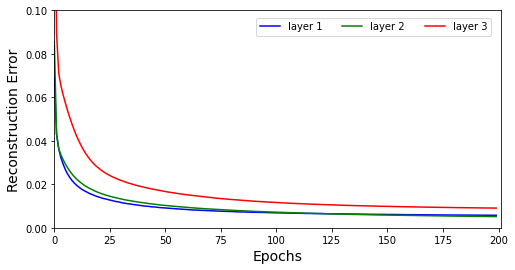

dataset6: 551 of 551 mini-batches from (55021, 63)
dataset7: 1 of 1 mini-batches from (13755, 63)
downhill: compiling evaluation function
downhill: compiling ADADELTA optimizer
downhill: setting: rms_halflife = 14
downhill: setting: rms_regularizer = 1e-08
downhill: setting: patience = 1
downhill: setting: validate_every = 5
downhill: setting: min_improvement = 0.001
downhill: setting: max_gradient_norm = 0
downhill: setting: max_gradient_elem = 0
downhill: setting: learning_rate = TensorConstant{0.0001}
downhill: setting: momentum = 0.0
downhill: setting: nesterov = False
downhill: validation 0 loss=0.014176 *
downhill: ADADELTA 1 loss=0.010302
downhill: ADADELTA 2 loss=0.008113
downhill: ADADELTA 3 loss=0.006987
downhill: ADADELTA 4 loss=0.006281
downhill: ADADELTA 5 loss=0.005748
downhill: validation 1 loss=0.005502 *
downhill: ADADELTA 6 loss=0.005326
downhill: ADADELTA 7 loss=0.004991
downhill: ADADELTA 8 loss=0.004734
downhill: ADADELTA 9 loss=0.004532
downhill: ADADELTA 10 loss=

In [ ]:
sda, re = train_SdAE(pre_lr       = 1e-2,             
                    end2end_lr   = 1e-4,
                    algo         = 'adadelta',
                    dataset      = datasets,
                    data_name    = data,
                    n_validate   = n_vali,
                    norm         = norm,
                    batch_size   = batch,
                    hidden_sizes = h_sizes,
                    corruptions  = corruptions,
                    patience     = pat,
                    validation   = val)


#*******Computer AUC on hidden data*************
lof,cen,dis,kde,svm05,svm01,ae  = sda.Compute_AUC_Hidden(train_X, test_X, actual, norm, data)
auc_hidden = np.column_stack([batch, re[0], lof, cen, dis, kde, svm05, svm01, ae , 100*re[2]])
AUC_Hidden = np.append(AUC_Hidden, auc_hidden)


In [19]:
AUC_Hidden  =  np.reshape(AUC_Hidden, (-1, 10))
np.set_printoptions(precision=3, suppress=True)
column_list = [2,3,4,5,6,7,8,9]
print("    LOF    CEN    MDIS   KDE   SVM5    SVM1    AE    RE*100")
print (AUC_Hidden[:,column_list])

    LOF    CEN    MDIS   KDE   SVM5    SVM1    AE    RE*100
[[0.277 0.689 0.687 0.684 0.356 0.112 0.976 0.031]]


In [20]:
AUC_Hidden  =  np.reshape(AUC_Hidden, (-1, 10))
np.set_printoptions(precision=3, suppress=True)
column_list = [2,3,4,5,6,7,8,9]
print("    LOF    CEN    MDIS   KDE   SVM5    SVM1    AE    RE*100")
print (AUC_Hidden[:,column_list])

    LOF    CEN    MDIS   KDE   SVM5    SVM1    AE    RE*100
[[0.277 0.689 0.687 0.684 0.356 0.112 0.976 0.031]]
